In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Real-Time Traffic Prediction") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

In [ ]:
# Step 2: Load Dataset
# Assuming the dataset is in CSV format with columns: ['hour', 'traffic_volume', 'weather', 'day_of_week']
data = spark.read.csv("dataset.csv", header=True, inferSchema=True)

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/dataset.csv.

In [ ]:
data.describe().show()

pandas_df = data.toPandas()

+-------+---------+--------+------------------+-----------------+------------------+------------------+------------------+
|summary|      Day|    Date|          CodedDay|             Zone|           Weather|       Temperature|           Traffic|
+-------+---------+--------+------------------+-----------------+------------------+------------------+------------------+
|  count|     1439|    1439|              1439|             1439|              1439|              1439|              1439|
|   mean|     NULL|    NULL|4.0006949270326615|72.54968728283531|23.886031966643504|25.011118832522584|3.0319666435024324|
| stddev|     NULL|    NULL|1.7330541157739279|41.55432958099291|13.576786958577042|11.325375587439831| 1.429018145859362|
|    min|   Friday|01-06-18|                 1|                1|                 0|                 6|                 1|
|    max|Wednesday|10-06-18|                 7|              144|                47|                45|                 5|
+-------+-------

In [ ]:
print(data.head(5))

[Row(Day='Wednesday', Date='01-06-18', CodedDay=3, Zone=2, Weather=35, Temperature=17, Traffic=2), Row(Day='Wednesday', Date='01-06-18', CodedDay=3, Zone=3, Weather=36, Temperature=16, Traffic=3), Row(Day='Wednesday', Date='01-06-18', CodedDay=3, Zone=4, Weather=27, Temperature=25, Traffic=5), Row(Day='Wednesday', Date='01-06-18', CodedDay=3, Zone=5, Weather=23, Temperature=23, Traffic=3), Row(Day='Wednesday', Date='01-06-18', CodedDay=3, Zone=6, Weather=18, Temperature=42, Traffic=2)]


In [ ]:
pandas_df = data.toPandas()


In [ ]:
pandas_df.dropna(inplace=True)

<ipython-input-35-eab0cda8c7b4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_df, x="CodedDay", y="Traffic", palette="muted")


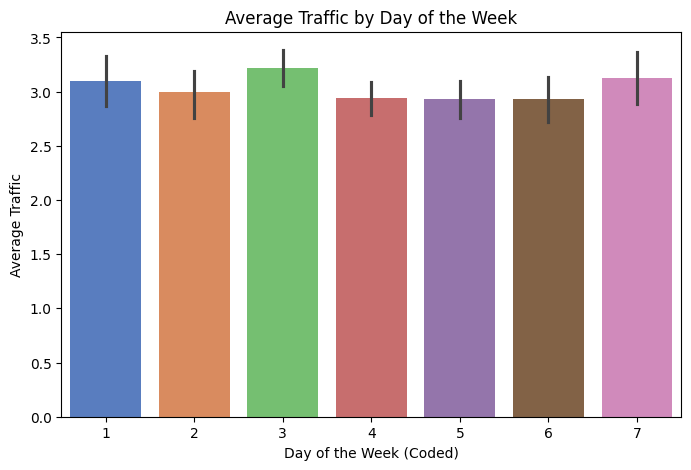

In [ ]:
# Plot 1 - Bar Plot: Traffic by CodedDay
plt.figure(figsize=(8, 5))
sns.barplot(data=pandas_df, x="CodedDay", y="Traffic", palette="muted")
plt.title("Average Traffic by Day of the Week")
plt.xlabel("Day of the Week (Coded)")
plt.ylabel("Average Traffic")
plt.show()

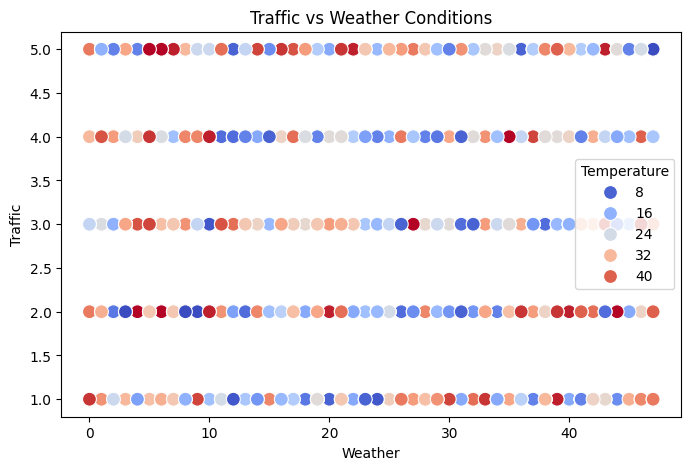

In [ ]:
# Plot 2 - Scatter Plot: Traffic vs Weather
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pandas_df, x="Weather", y="Traffic", hue="Temperature", palette="coolwarm", s=100)
plt.title("Traffic vs Weather Conditions")
plt.xlabel("Weather")
plt.ylabel("Traffic")
plt.show()

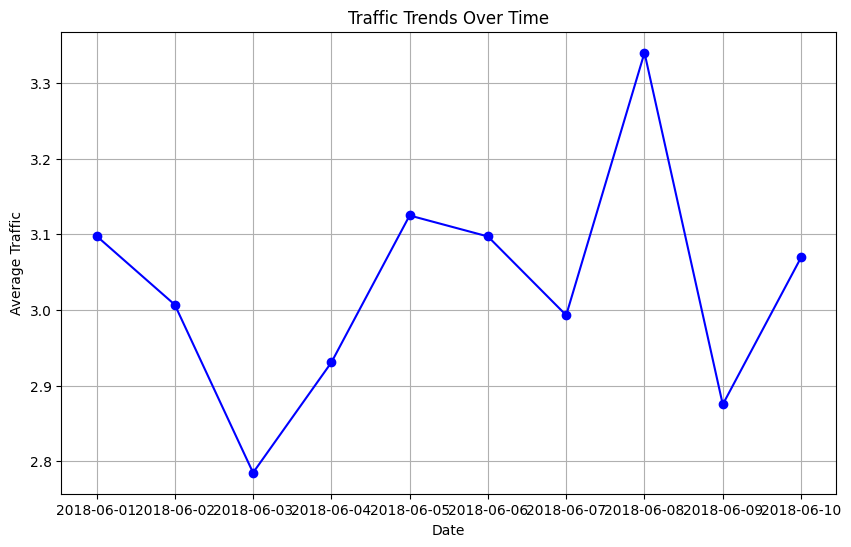

In [ ]:
# Plot 3 - Line Plot: Traffic Trends Over Time
import pandas as pd
pandas_df["Date"] = pd.to_datetime(pandas_df["Date"], format="%d-%m-%y")
traffic_trends = pandas_df.groupby("Date")["Traffic"].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(traffic_trends["Date"], traffic_trends["Traffic"], marker="o", linestyle="-", color="b")
plt.title("Traffic Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Average Traffic")
plt.grid(True)
plt.show()

<ipython-input-38-518d1dbd152f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_df, x="Zone", y="Traffic", palette="viridis")


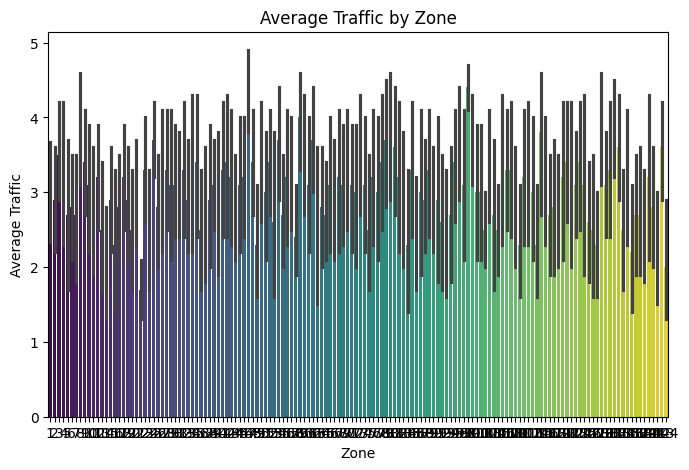

In [ ]:
# Plot 4 - Bar Plot: Average Traffic by Zone
plt.figure(figsize=(8, 5))
sns.barplot(data=pandas_df, x="Zone", y="Traffic", palette="viridis")
plt.title("Average Traffic by Zone")
plt.xlabel("Zone")
plt.ylabel("Average Traffic")
plt.show()

In [ ]:
# Step 3: Select Relevant Features
# We'll use CodedDay, Zone, Weather, and Temperature as features for the model.
feature_columns = ['CodedDay', 'Zone', 'Weather', 'Temperature']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

In [ ]:
# Step 4: Data Preparation
# Define 'Traffic' as the label (target variable)
data = data.withColumnRenamed("Traffic", "label")

In [ ]:
# Step 5: Split Data into Training and Test Sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Step 6: Train Machine Learning Model
lr = LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction")
lr_model = lr.fit(train_data)

In [ ]:
# Step 7: Evaluate the Model
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

In [ ]:
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.3741237861467062


In [ ]:
# Simulating real-time data
real_time_data = spark.createDataFrame([
    (3, 2, 35, 17)  # Example input: (CodedDay, Zone, Weather, Temperature)
], schema=["CodedDay", "Zone", "Weather", "Temperature"])

real_time_data = assembler.transform(real_time_data)
real_time_predictions = lr_model.transform(real_time_data)

In [ ]:
# Display predictions
real_time_predictions.select("CodedDay", "Zone", "Weather", "Temperature", "prediction").show()

+--------+----+-------+-----------+-----------------+
|CodedDay|Zone|Weather|Temperature|       prediction|
+--------+----+-------+-----------+-----------------+
|       3|   2|     35|         17|2.994350504355437|
+--------+----+-------+-----------+-----------------+



In [ ]:
spark.stop()